# Librares

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydot
import kymatio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from termcolor import colored
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.figure_factory as ff
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from kymatio import Scattering1D
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

c:\Users\Shuvashis\anaconda3\envs\Tempura\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
#import tensorflow_io as tfio

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

# CallBacks

In [4]:
epochs = 20

model_file_path = "best_model_file.hdf5"
checkpoint = ModelCheckpoint(model_file_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,  # <-- Corrected value
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = tf.keras.callbacks.CSVLogger('Model.log')

# Define a learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate,
    decay_steps=10000,
    end_learning_rate=0.000001,
    power=0.5,
    cycle=False
)


callbacks = [earlystop, csv_logger, reduce_lr, checkpoint]

# Dataset

In [5]:
os.listdir(r'D:\MIET_HeartSound\Dataset\Dataset2\heart_sound')
data = os.path.join(r'D:\MIET_HeartSound\Dataset\Dataset2\heart_sound')
data

'D:\\MIET_HeartSound\\Dataset\\Dataset2\\heart_sound'

In [6]:
train_dir_path = os.path.join(data, 'train')
valid_dir_path = os.path.join(data, 'val')

In [7]:
healthy = os.path.join(train_dir_path, 'healthy', 'a0007.wav')
unhealthy = os.path.join(train_dir_path, 'unhealthy', 'a0002.wav')

In [8]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    print(wav, sample_rate)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    print(wav, sample_rate)
    
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

tf.Tensor(
[[0.04437256]
 [0.09277344]
 [0.08206177]
 ...
 [0.01379395]
 [0.01266479]
 [0.01278687]], shape=(71332, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor([0.04437256 0.09277344 0.08206177 ... 0.01379395 0.01266479 0.01278687], shape=(71332,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(
[[ 0.00906372]
 [ 0.0222168 ]
 [ 0.02377319]
 ...
 [-0.0027771 ]
 [-0.00247192]
 [-0.00201416]], shape=(41657, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[ 0.00906372  0.0222168   0.02377319 ... -0.0027771  -0.00247192
 -0.00201416], shape=(41657,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)


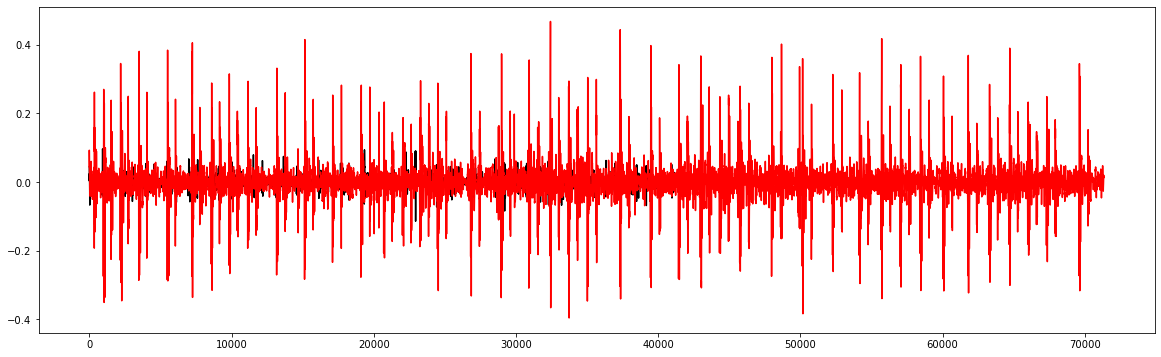

In [9]:
wave = load_wav_16k_mono(healthy)
nwave = load_wav_16k_mono(unhealthy)

plt.figure(figsize=(20, 6))
plt.plot(nwave, color='black')
plt.plot(wave, color='red')
plt.show()

In [10]:
healthy_heart_train = tf.data.Dataset.list_files(train_dir_path+'/healthy'+'/*.wav')
unhealthy_heart_train = tf.data.Dataset.list_files(train_dir_path+'/unhealthy'+'/*.wav')
#healthy_heart_valid = tf.data.Dataset.list_files(valid_dir_path+'/healthy'+'/*.wav')
#unhealthy_heart_valid = tf.data.Dataset.list_files(valid_dir_path+'/unhealthy'+'/*.wav')

In [11]:
hhl_train = tf.data.Dataset.zip((healthy_heart_train, tf.data.Dataset.from_tensor_slices(tf.ones(len(healthy_heart_train)))))
uhl_train = tf.data.Dataset.zip((unhealthy_heart_train, tf.data.Dataset.from_tensor_slices(tf.zeros(len(unhealthy_heart_train)))))
train_data = hhl_train.concatenate(uhl_train)

#hhl_valid = tf.data.Dataset.zip((healthy_heart_valid, tf.data.Dataset.from_tensor_slices(tf.ones(len(healthy_heart_valid)))))
#uhl_valid = tf.data.Dataset.zip((unhealthy_heart_valid, tf.data.Dataset.from_tensor_slices(tf.zeros(len(unhealthy_heart_valid)))))
#valid_data = hhl_valid.concatenate(uhl_valid)

In [12]:
#train_data = train_data.concatenate(valid_data)
lengths = []
for f in os.listdir(os.path.join(train_dir_path, 'healthy')):
    tensor_wave = load_wav_16k_mono(os.path.join(train_dir_path, 'healthy', f))
    lengths.append(len(tensor_wave))

tf.Tensor(
[[0.04437256]
 [0.09277344]
 [0.08206177]
 ...
 [0.01379395]
 [0.01266479]
 [0.01278687]], shape=(71332, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor([0.04437256 0.09277344 0.08206177 ... 0.01379395 0.01266479 0.01278687], shape=(71332,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(
[[-0.00408936]
 [-0.00686646]
 [-0.00848389]
 ...
 [ 0.00643921]
 [ 0.00888062]
 [ 0.00592041]], shape=(71611, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[-0.00408936 -0.00686646 -0.00848389 ...  0.00643921  0.00888062
  0.00592041], shape=(71611,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(
[[-5.7983398e-04]
 [-1.3427734e-03]
 [-1.2207031e-03]
 ...
 [ 3.0517578e-05]
 [ 5.4931641e-04]
 [ 5.4931641e-04]], shape=(71193, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[-5.7983398e-04 -1.3427734e-03 -1.2207031e-03 ...  3.0517578e-05
  5.4931641e-04  5.4931641e-04], shape=(71193,), dtype=flo

In [13]:
# Calculate the lengths
train_length = tf.data.experimental.cardinality(train_data).numpy()
#valid_length = tf.data.experimental.cardinality(valid_data).numpy()

# Print the lengths
print("Length of train_data:", train_length)
#print("Length of valid_data:", valid_length)

Length of train_data: 3240


In [14]:
import librosa
J = 6
Q = 1
T = 30000
scatt = Scattering1D(J, T, Q)
def extract(file_path, label, wav_length=30000):
    def mfccs(wav):
        # Ensure wav is a numpy array
        wav = wav.numpy()
        
        mfcc = librosa.feature.mfcc(y=wav, sr=2000, n_mfcc=7)
        return mfcc

    
    
    def scattering_transform(wav):
        # Ensure wav is a numpy array
        wav = wav.numpy()
        
        meta = scatt.meta()
        order0 = np.where(meta['order'] == 0)
        order1 = np.where(meta['order'] == 1)
        order2 = np.where(meta['order'] == 2)

        Sx = scatt(wav) 
        return Sx[order1]
    
    wav = load_wav_16k_mono(file_path)
    wav = tf.cast(wav, dtype=tf.float32)  # Ensure wav is float32
    wav = wav / tf.reduce_max(tf.abs(wav))
    wav = wav[:wav_length] if tf.shape(wav)[0] > wav_length else tf.pad(wav, [(0, wav_length - tf.shape(wav)[0])], "CONSTANT")
    
    # Using tf.py_function to wrap the scattering transform
    mfcc = tf.py_function(mfccs, [wav], tf.float32)
    mfcc = tf.abs(mfcc)

    # Using tf.py_function to wrap the scattering transform
    scattering_transform = tf.py_function(scattering_transform, [wav], tf.float32)
    scattering_transform = tf.abs(scattering_transform)
    # You might need to set the shape of the output manually if required
    scattering_transform.set_shape((7, 469)) 
    
    concatenated_feature = tf.concat([scattering_transform, mfcc] , axis = 1)
    concatenated_feature = tf.expand_dims(concatenated_feature, axis = 2)
    
    return concatenated_feature, label

In [15]:
iterator = hhl_train.shuffle(buffer_size=10000).as_numpy_iterator()
iterator.next()
filepath, label = next(iterator)
print(filepath, label)

b'D:\\MIET_HeartSound\\Dataset\\Dataset2\\heart_sound\\train\\healthy\\e00511.wav' 1.0


In [16]:
feature, label = extract(filepath, label)
print(feature)


tf.Tensor(
[[-0.07125854]
 [-0.0687561 ]
 [-0.06500244]
 ...
 [-0.01126099]
 [-0.00875854]
 [-0.01126099]], shape=(68736, 1), dtype=float32) tf.Tensor(2000, shape=(), dtype=int32)
tf.Tensor(
[-0.07125854 -0.0687561  -0.06500244 ... -0.01126099 -0.00875854
 -0.01126099], shape=(68736,), dtype=float32) tf.Tensor(2000, shape=(), dtype=int64)
tf.Tensor(
[[[2.14285357e-03]
  [2.02181167e-03]
  [1.82538282e-03]
  ...
  [2.18276230e+02]
  [2.17560623e+02]
  [1.52267029e+02]]

 [[4.83513996e-03]
  [4.63685673e-03]
  [4.30068979e-03]
  ...
  [1.19290382e+02]
  [1.15875664e+02]
  [9.86825867e+01]]

 [[1.22641763e-02]
  [1.21064670e-02]
  [1.16255404e-02]
  ...
  [9.18457184e+01]
  [8.90641937e+01]
  [6.42180176e+01]]

 ...

 [[1.76258329e-02]
  [1.50319375e-02]
  [1.10651040e-02]
  ...
  [2.41555309e+01]
  [2.12642860e+01]
  [2.88164597e+01]]

 [[1.02970228e-02]
  [8.81613977e-03]
  [6.42565871e-03]
  ...
  [1.51099911e+01]
  [1.13040018e+01]
  [1.72179260e+01]]

 [[1.60011428e-03]
  [1.34212000

In [17]:
train_data = train_data.map(extract)
train_data = train_data.cache()
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(4)
train_data = train_data.prefetch(2)

Tensor("DecodeWav:0", shape=(None, 1), dtype=float32) Tensor("DecodeWav:1", shape=(), dtype=int32)
Tensor("Squeeze:0", shape=(None,), dtype=float32) Tensor("Cast:0", shape=(), dtype=int64)


In [18]:
num_samples = tf.data.experimental.cardinality(train_data).numpy()
print(f"Number of samples in train_data: {num_samples}")

Number of samples in train_data: 810


In [19]:
train = train_data.take(567)
test = train_data.skip(567).take(243)
samples, labels = train.as_numpy_iterator().next()
print(samples.shape)
print(labels)

(4, 7, 528, 1)
[1. 1. 1. 1.]


In [20]:
# Calculate the lengths
train_length = tf.data.experimental.cardinality(train).numpy()
test_length = tf.data.experimental.cardinality(test).numpy()

# Print the lengths
print("Length of train:", train_length)
print("Length of test:", test_length)

Length of train: 567
Length of test: 243


# Model

# CNN

In [21]:
def cnn():
    model = Sequential()
    model.add(Conv2D(16, (2,2), activation='relu', input_shape=(7, 528, 1)))
    model.add(Conv2D(32, (2,2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [22]:
# Create an optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model0 = cnn()
model0.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 527, 16)        80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 526, 32)        2080      
_________________________________________________________________
flatten (Flatten)            (None, 84160)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               10772608  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 10,774,897
Trainable params: 10,774,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 64

history0 = model0.fit(train, 
                    batch_size=batch_size, 
                    epochs=200,
                    validation_data=test,
                    verbose=1,
                    )

Epoch 1/200
567/567 [==============================] - 5s 8ms/step - loss: 0.1973 - accuracy: 0.9220 - val_loss: 0.6751 - val_accuracy: 0.5154
Epoch 2/200
567/567 [==============================] - 4s 8ms/step - loss: 0.1868 - accuracy: 0.9131 - val_loss: 0.6637 - val_accuracy: 0.5165
Epoch 3/200
567/567 [==============================] - 5s 8ms/step - loss: 0.1799 - accuracy: 0.9158 - val_loss: 0.6545 - val_accuracy: 0.5134
Epoch 4/200
567/567 [==============================] - 4s 8ms/step - loss: 0.1821 - accuracy: 0.9034 - val_loss: 0.6509 - val_accuracy: 0.5000
Epoch 5/200
567/567 [==============================] - 4s 8ms/step - loss: 0.1693 - accuracy: 0.9175 - val_loss: 0.6439 - val_accuracy: 0.6430
Epoch 6/200
567/567 [==============================] - 4s 8ms/step - loss: 0.1654 - accuracy: 0.9295 - val_loss: 0.6213 - val_accuracy: 0.7191
Epoch 7/200
567/567 [==============================] - 5s 8ms/step - loss: 0.1691 - accuracy: 0.9233 - val_loss: 0.6110 - val_accuracy: 0.7058

In [24]:
import numpy as np

def butterfly_optimization(n, fitness, dimension, lb, ub, max_iter):
    # Initialize population
    population = np.random.rand(n, dimension) * (ub - lb) + lb
    fitness_population = np.array([fitness(ind) for ind in population])
    
    # BOA parameters
    sensory_modality = 0.01  # Sensory modality (perception)
    
    for _ in range(max_iter):
        # Update butterflies
        for i in range(n):
            if np.random.rand() < sensory_modality:
                # Global search
                j = np.random.randint(0, n)  # Random butterfly index
                step_size = np.random.rand() * (population[j] - population[i])
            else:
                # Local search
                step_size = np.random.normal(0, 1, dimension)
            
            # Move butterfly
            population[i] += step_size
            population[i] = np.clip(population[i], lb, ub)  # Keep within bounds
            print("Calculating")
            # Evaluate new solution
            new_fitness = fitness(population[i])
            if new_fitness < fitness_population[i]:
                fitness_population[i] = new_fitness
                print('Found new fitness: ', new_fitness)
    
    # Return the best solution
    best_idx = np.argmin(fitness_population)
    return population[best_idx]


In [25]:
def model_fitness(hyperparams):
    learning_rate, batch_size = hyperparams
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = cnn()  # Your CNN model function
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    # Assuming `train` and `test` are predefined datasets
    history = model.fit(train, batch_size=int(batch_size), epochs=10, validation_data=test, verbose=0)
    val_accuracy = np.max(history.history['val_accuracy'])  # Max validation accuracy
    
    return -val_accuracy  # Negative because BOA minimizes the fitness function


In [26]:
best_hyperparams = butterfly_optimization(
    n=10, 
    fitness=model_fitness, 
    dimension=2, 
    lb=np.array([1e-5, 8]),  # Lower bounds for learning rate and batch size
    ub=np.array([1e-2, 64]),  # Upper bounds
    max_iter=20
)

print(f"Best Hyperparameters: Learning Rate = {best_hyperparams[0]}, Batch Size = {int(best_hyperparams[1])}")


Calculating
Calculating
Found new fitness:  -0.8847736716270447
Calculating
Found new fitness:  -0.7644032835960388
Calculating
Found new fitness:  -0.8487654328346252
Calculating
Calculating
Found new fitness:  -0.8497942090034485
Calculating
Calculating
Found new fitness:  -0.8518518805503845
Calculating
Found new fitness:  -0.8220164775848389
Calculating
Calculating
Calculating
Calculating
Found new fitness:  -0.7705761194229126
Calculating
Found new fitness:  -0.8611111044883728
Calculating
Calculating
Calculating
Calculating
Calculating
Found new fitness:  -0.8497942090034485
Calculating
Found new fitness:  -0.8168724179267883
Calculating
Calculating
Calculating
Found new fitness:  -0.8528806567192078
Calculating
Calculating
Found new fitness:  -0.8508230447769165
Calculating
Calculating
Calculating
Calculating
Calculating
Found new fitness:  -0.854938268661499
Calculating
Calculating
Calculating
Found new fitness:  -0.8744856119155884
Calculating
Calculating
Calculating
Found new

In [21]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np


# Define Objective Function
def objective_function(learning_rate, stride, dense_layer, num_filters, batch_size, epochs):
    model = build_model(learning_rate, stride, num_filters, dense_layer)
    
    # Train model
    history = model.fit(train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=test,
                    verbose=1,
                    )
    
    # Return validation accuracy as score
    return history.history['val_accuracy'][-1]

# Define Model Builder
def build_model(learning_rate, stride, num_filters, dense_layer):
    model = tf.keras.Sequential([
        layers.Conv2D(num_filters[0], (stride[0],stride[0]), activation='relu', input_shape=(7, 528, 1)),
        layers.Conv2D(num_filters[1], (stride[1],stride[1]), activation='relu'),
        layers.Flatten(),
        layers.Dense(dense_layer, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Butterfly Optimization Function
def butterfly_optimization(objective_function, initial_hyperparameters, num_butterflies=10, max_iterations=50):
    global_best_hyperparameters = initial_hyperparameters.copy()
    global_best_score = objective_function(**initial_hyperparameters)

    for iteration in range(max_iterations):
        for butterfly in range(num_butterflies):
            updated_hyperparameters = {}
            for param, value in initial_hyperparameters.items():
                if isinstance(value, float):
                    updated_value = value + np.random.normal(0, 0.1)
                    updated_hyperparameters[param] = np.clip(updated_value, 0.001, None)  # Ensure non-negative values
                elif isinstance(value, list):
                    updated_value = [int(np.round(v + np.random.normal(0, 0.1))) for v in value]
                    updated_hyperparameters[param] = [np.clip(v, 1, None) for v in updated_value]  # Ensure positive integers
                else:
                    updated_hyperparameters[param] = value
                
            score = objective_function(**updated_hyperparameters)
            print('Score:', score, '\nParameters: ', updated_hyperparameters)
            if score > global_best_score:
                print('Global: ', updated_hyperparameters)
                global_best_score = score
                global_best_hyperparameters = updated_hyperparameters.copy()
        
        # Implement exploration and exploitation adjustments if needed
        
    return global_best_hyperparameters


# Define initial hyperparameters
initial_hyperparameters = {
    'learning_rate': 1e-5,
    'num_filters': [32, 32],
    'stride': [3, 3],
    'epochs': 50,
    'dense_layer':256,
    'batch_size': 32
}

# Run Butterfly Optimization
best_hyperparameters = butterfly_optimization(objective_function, initial_hyperparameters)

print("Best Hyperparameters:", best_hyperparameters)


Epoch 1/50
567/567 [==============================] - 112s 140ms/step - loss: 0.4605 - accuracy: 0.9149 - val_loss: 0.7698 - val_accuracy: 0.7490
Epoch 2/50
567/567 [==============================] - 2s 4ms/step - loss: 0.2521 - accuracy: 0.9206 - val_loss: 0.5483 - val_accuracy: 0.7716
Epoch 3/50
567/567 [==============================] - 2s 4ms/step - loss: 0.2429 - accuracy: 0.9237 - val_loss: 0.7098 - val_accuracy: 0.7912
Epoch 4/50
567/567 [==============================] - 2s 4ms/step - loss: 0.1796 - accuracy: 0.9387 - val_loss: 0.4825 - val_accuracy: 0.7706
Epoch 5/50
567/567 [==============================] - 2s 4ms/step - loss: 0.1982 - accuracy: 0.9352 - val_loss: 0.4311 - val_accuracy: 0.7870
Epoch 6/50
567/567 [==============================] - 2s 4ms/step - loss: 0.1326 - accuracy: 0.9511 - val_loss: 0.4093 - val_accuracy: 0.8292
Epoch 7/50
567/567 [==============================] - 2s 4ms/step - loss: 0.1365 - accuracy: 0.9427 - val_loss: 0.4546 - val_accuracy: 0.7798
Ep

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Step 4: Make predictions and evaluate on the test set
true_labels = []
predicted_labels = []

for samples, labels in test.as_numpy_iterator():
    predictions = model0.predict(samples)
    predicted_classes = (predictions > 0.5).astype(int)  # Adjust threshold as needed for binary classification
    true_labels.extend(labels)
    predicted_labels.extend(predicted_classes)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 5: Classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
print(confusion_matrix(true_labels, predicted_labels))

1/1 [==============================] - 0s 26ms/step
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       468
         1.0       0.94      0.89      0.91       504

    accuracy                           0.91       972
   macro avg       0.91      0.91      0.91       972
weighted avg       0.91      0.91      0.91       972

[[440  28]
 [ 57 447]]
